## <b><font color='darkblue'>Preface</font></b>
([Source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021201-chapter-2-instructing-the-app/9838472-reviewing-the-workflow-and-chatbot)) Reviewing the workflow and chatbot

### <b><font color='darkgreen'>Section 1: Reviewing the workflow and chatbot</font></b>

In [6]:
import getpass
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import MemorySaver

_ = load_dotenv()

In [3]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [28]:
message = model.invoke('What is 1+2?')
message

AIMessage(content='1 + 2 = 3', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--89a90f41-5315-45ea-9d9f-30786c8edf91-0', usage_metadata={'input_tokens': 7, 'output_tokens': 8, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}})

In [29]:
message.content

'1 + 2 = 3'

In [16]:
def call_model(state: MessagesState):
    updated_messages = model.invoke(state["messages"])
    return {"messages": updated_messages}

workflow = StateGraph(MessagesState)
workflow.add_node("model_node", call_model)
workflow.add_edge(START, "model_node")

memory = MemorySaver()
app = workflow.compile(memory)

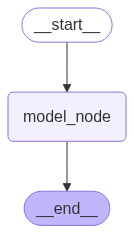

In [17]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [18]:
def chatbot(chat_id: int):
    config = {"configurable": {"thread_id": chat_id}}

    while True:
        user_input = input("User:")

        if user_input in ["exit", "quit"]:
            print("AI: See you later!")
            break
        
        else:
            print("AI: ", end="")
            for chunk, metadata in app.stream({"messages": user_input}, config, stream_mode="messages"):
                print(chunk.content, end="", flush=True)
            print("\n")

In [19]:
chatbot(0)

User: What is 1+1?


AI: 1 + 1 = 2




User: exit


AI: See you later!


### <b><font color='darkgreen'>Section 2: Adding a system prompt</font></b>
([Source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021201-chapter-2-instructing-the-app/9850941-adding-a-system-prompt)) [**LangChain Messages**](https://python.langchain.com/docs/concepts/messages/#langchain-messages): LangChain provides a unified message format that can be used across all chat models, allowing users to work with different chat models without worrying about the specific details of the message format used by each model provider.

LangChain messages are Python objects that subclass from a [**BaseMessage**](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.base.BaseMessage.html). The five main message types are:
* [**SystemMessage**](https://python.langchain.com/docs/concepts/messages/#systemmessage): corresponds to system role
* [**HumanMessage**](https://python.langchain.com/docs/concepts/messages/#humanmessage): corresponds to user role
* [**AIMessage**](https://python.langchain.com/docs/concepts/messages/#aimessage): corresponds to assistant role
* [**AIMessageChunk**](https://python.langchain.com/docs/concepts/messages/#aimessagechunk): corresponds to assistant role, used for streaming responses
* [**ToolMessage**](https://python.langchain.com/docs/concepts/messages/#toolmessage): corresponds to tool role

Below we will leverage [**ChatPromptTemplate**](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html#chatprompttemplate) to compose system message with human message:

In [32]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate([
    ('system', 'Limit all of your responses to two sentences.'),
    ("placeholder", "{messages}"),
])

In [33]:
state = {'messages': ['What is the history of AI?']}

In [34]:
prompt.invoke(state)

ChatPromptValue(messages=[SystemMessage(content='Limit all of your responses to two sentences.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the history of AI?', additional_kwargs={}, response_metadata={})])

In [36]:
resp = model.invoke(prompt.invoke(state))
resp

AIMessage(content='The history of AI began in the mid-20th century with pioneers exploring symbolic reasoning and early neural networks. Over the decades, AI has experienced periods of excitement and setbacks, leading to the current era of machine learning and deep learning.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--90fe9675-1b64-4f1c-99d0-cced4f2c17d2-0', usage_metadata={'input_tokens': 16, 'output_tokens': 49, 'total_tokens': 65, 'input_token_details': {'cache_read': 0}})

In [37]:
resp.content

'The history of AI began in the mid-20th century with pioneers exploring symbolic reasoning and early neural networks. Over the decades, AI has experienced periods of excitement and setbacks, leading to the current era of machine learning and deep learning.'

### <b><font color='darkgreen'>Section 3: Chaining multiple actions</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021201-chapter-2-instructing-the-app/9851093-chaining-multiple-actions)) One point about [**LangChain Expression Language**](https://python.langchain.com/docs/concepts/lcel/) is that any two [**Runable**](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.base.Runnable.html)s can be "chained" together into sequences.

The output of the previous runnable's `.invoke()` call is passed as input to the next runnable. This can be done using the pipe operator (`|`), or the more explicit `.pipe()` method, which does the same thing ([more](https://python.langchain.com/docs/how_to/sequence/)).

In [38]:
chain = prompt | model

In [39]:
state = {'messages': ['What is the history of LLM?']}
chain.invoke(state).content

'LLMs evolved from earlier natural language processing models, gaining prominence with the introduction of transformers in 2017. These models have since grown in size and capability, leading to significant advancements in various language-based tasks.'

### <b><font color='darkgreen'>Section 4: Calling the model</font></b>
Let's apply what we learn from previous section to rewrite our chat app:

In [43]:
from functools import partial

def call_model(state: MessagesState, prompt, model):
    chain = prompt | model
    updated_messages = chain.invoke(state)
    return {"messages": updated_messages}


short_chinese_prompt = ChatPromptTemplate([
    ('system', 'Limit all of your responses to two sentences and use Chinese.'),
    ("placeholder", "{messages}"),
])
short_chinese_call_model = partial(call_model, prompt=short_chinese_prompt, model=model)
workflow = StateGraph(MessagesState)
workflow.add_node("model_node", short_chinese_call_model)
workflow.add_edge(START, "model_node")

memory = MemorySaver()
chinese_app = workflow.compile(memory)

In [41]:
def chatbot(chat_id: int, app):
    config = {"configurable": {"thread_id": chat_id}}

    while True:
        user_input = input("User:")

        if user_input in ["exit", "quit"]:
            print("AI: See you later!")
            break
        
        else:
            print("AI: ", end="")
            for chunk, metadata in app.stream({"messages": user_input}, config, stream_mode="messages"):
                print(chunk.content, end="", flush=True)
            print("\n")

In [44]:
chatbot(0, chinese_app)

User: What is the history of machine learning?


AI: 机器学习起源于20世纪50年代，并在随后的几十年里经历了多次发展和变革。它从最初的符号主义方法逐渐发展到统计学习和深度学习等更复杂的技术。




User: exit


AI: See you later!


### <b><font color='darkgreen'>Section 5: Reviewing the updated workflow</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021201-chapter-2-instructing-the-app/9966020-reviewing-the-updated-workflow)) Let's pull things together in one cell:

In [48]:

import getpass
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import MemorySaver

_ = load_dotenv()


model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

short_chinese_prompt = ChatPromptTemplate([
    ('system', 'Limit all of your responses to two sentences and use Traditional Chinese.'),
    ("placeholder", "{messages}"),
])


chain = short_chinese_prompt | model


def call_model(state: MessagesState, chain=chain):
    updated_messages = chain.invoke(state)
    return {"messages": updated_messages}


workflow = StateGraph(MessagesState)
workflow.add_node("model_node", call_model)
workflow.add_edge(START, "model_node")

memory = MemorySaver()
chinese_app = workflow.compile(memory)


def chatbot(chat_id: int, app=chinese_app):
    config = {"configurable": {"thread_id": chat_id}}

    while True:
        user_input = input("User:")

        if user_input in ["exit", "quit"]:
            print("AI: See you later!")
            break
        
        else:
            print("AI: ", end="")
            for chunk, metadata in app.stream({"messages": user_input}, config, stream_mode="messages"):
                print(chunk.content, end="", flush=True)
            print("\n")

In [49]:
chatbot(0)

User: What is the history of RAG?


AI: RAG (檢索增強生成) 的歷史相對較新，它源於對大型語言模型在知識密集型任務中局限性的認識。這種方法旨在通過從外部知識源檢索相關信息來增強模型的生成能力，從而提高其準確性和可靠性。




User: exit


AI: See you later!
